<img src="../../images/BikeDNA_logo.svg" width="250"  alt="BikeDNA logo" style="display:block; margin-left: auto; margin-right: auto;">
<a href="https://github.com/anerv/BikeDNA">Github</a>

# 3b. Feature Matching

The feature matching takes the reference data and attempts to identify corresponding features in the OSM data set. Feature matching is a necessary precondition to compare single features rather than feature characteristics on study area a grid cell level.

**Method**

Matching features in two road data sets with each their way of digitizing features and a potential one-to-many relationship between edges (for example in the case where one data set only maps road center lines, while the other map the geometries of each bike lane) is not a trivial task.

The method used here converts all network edges to smaller segments of a uniform length before looking for a potential match between the reference and the OSM data. The matching is done on the basis of the buffered distance between objects, the angle, and the undirected Hausdorff distance, and is based on the works of [Koukoletsos et al. (2012)](http://www.geog.leeds.ac.uk/groups/geocomp/2011/papers/koukoletsos.pdf) and [Will (2014)](https://www.semanticscholar.org/paper/Development-of-an-automated-matching-algorithm-to-%3A-Will/b3b77d579077b967820630db56522bef31654f21).

Based on the matching results, the following values are computed:
- The number and length of matched and unmatched edges, in total and per grid cell
- A comparison of the attributes of the matched edges: Is their classification of cycling infrastructure as protected or unprotected the same?

**Interpretation**

It is important to visually explore the feature matching results, since the success rate of the matching influences how the analysis of number of matches should be interpreted.

If the features in the two data sets have been digitized differently - e.g. if one data set has digitized bike tracks as mostly straight lines, while the other includes more winding tracks, the matching will fail. This is also the case if they are placed too far from each other. If it can be confirmed visually that the same features do exist in both data sets, a lack of matches indicates that the geometries in the two data sets are too different. If however it can be confirmed that most real corresponding features have been identified, a lack of matches in an area indicates errors of commission or omission.

<div class="alert alert-block alert-danger">
<b>Warning</b>
<p>
The feature matching is computationally expensive and will take a while to compute. For the testing data provided in this repository (with around 800 km of OSM network) the cell takes around 20 minutes to run.
</p>
</div>

**Sections**
* [Match features](#Match-features)
    * [Run and plot feature matching](#Run-and-plot-feature-matching)
    * [Matched and unmatched features](#Matched-and-unmatched-features)
    * [Feature matching summary](#Feature-matching-summary)
* [Analyze feature matching results](#Analyze-feature-matching-results)
    * [Matched features by infrastructure type](#Matched-features-by-infrastructure-type)
    * [Feature matching success](#Feature-matching-success)
* [Summary](#Summary)

<br />

In [1]:
# Load libraries, settings and data

import json
import numbers
import os.path
import pickle

import contextily as cx
import folium
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import osmnx as ox
import pandas as pd
import yaml

from src import evaluation_functions as eval_func
from src import matching_functions as match_func
from src import plotting_functions as plot_func

# Read in dictionaries with settings
%run ../settings/yaml_variables.py
%run ../settings/plotting.py
%run ../settings/tiledict.py
%run ../settings/paths.py

# # Load data
%run ../settings/load_osmdata.py
%run ../settings/load_refdata.py
%run ../settings/df_styler.py

grid = osm_grid.merge(
    ref_grid.drop('geometry',axis=1), on="grid_id", suffixes=("_osm", "_ref")
)

assert len(grid) == len(osm_grid) == len(ref_grid)

grid_ids = grid.grid_id.to_list()

/Users/anev/Library/CloudStorage/Dropbox/ITU/repositories/bikedna_denmark/scripts/settings/plotting.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name, n)
/Users/anev/Library/CloudStorage/Dropbox/ITU/repositories/bikedna_denmark/scripts/settings/plotting.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)


OSM graphs loaded successfully!
OSM data loaded successfully!
Reference graphs loaded successfully!
Reference data loaded successfully!


<string>:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
<string>:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


<div class="alert alert-block alert-info">
<b>User configurations</b>
<br>
<br>
For large datasets, the plotting can take as long as the actual analysis, if not more.
To allow for a faster execution of the notebook, use the above setting to control whether results are plotted or not. This only affects the plotting of new static and interactive maps - bar plots and maps from the intrinsic analyses are always plotted.
</div>

In [20]:
# USER INPUT: SET PLOTTING OF STATIC AND INTERACTIVE MAPS TO TRUE OF FALSE
plot_static_maps = False
plot_interactive_maps = False

for s in [plot_static_maps, plot_interactive_maps]:
    assert isinstance(s, bool), print(
        "Settings must be True or False!"
    )

print(f"Running notebook with plotting setting for static maps set to: {plot_static_maps}")
print(f"Running notebook with plotting setting for interactive maps set to: {plot_interactive_maps}")

Running notebook with plotting setting for static maps set to: False
Running notebook with plotting setting for interactive maps set to: False


## Match features

### Run and plot feature matching

<div class="alert alert-block alert-info">
<b>User configurations</b>
<br>
<br>
In the feature matching, the user must indicate:
<ul>
    <li>the segment length (length of the segments in meters that all features are split into before the matching) (<span style="font-family: monospace">segment_length</span>).</li>
    <li>the buffer distance used to find potential matches (i.e. the max distance between two segments that could represent the same object) (<span style="font-family: monospace">buffer_dist</span>).</li>
    <li>the maximum Hausdorff distance between features that can be considered matches (in this context it refers to the maximum distance between two geometries. For example, a segment A with a length of 25 meters might be within a 10 meter buffer distance of segment B, but if they are perpendicular to each other, the Hausdorff distance will be greater than 10 meters) (<span style="font-family: monospace">hausdorff_threshold</span>).</li>
    <li>the angular threshold between segments before they are no longer considered a potential match (<span style="font-family: monospace">angular_threshold</span>).</li>
</ul>
</div>

In [3]:
# Define feature matching user settings

segment_length = 10  # The shorter the segments, the longer the matching process will take. For cities with a gridded street network with streets as straight lines, longer segments will usually work fine
buffer_dist = 15
hausdorff_threshold = 17
angular_threshold = 30

for s in [segment_length, buffer_dist, hausdorff_threshold, angular_threshold]:
    assert isinstance(s, int) or isinstance(s, float), print(
        "Settings must be integer or float values!"
    )

In [4]:
osm_seg_fp = compare_processed_fp + f"osm_segments_{segment_length}.parquet"
ref_seg_fp = compare_processed_fp + f"ref_segments_{segment_length}.parquet"

if os.path.exists(osm_seg_fp) and os.path.exists(ref_seg_fp):

    osm_segments = gpd.read_parquet(osm_seg_fp)
    ref_segments = gpd.read_parquet(ref_seg_fp)

    print("Segments have already been created! Continuing with existing segment data.")
    print("\n")

else:
    print("Creating edge segments for OSM and reference data...")
    osm_segments = match_func.create_segment_gdf(
        osm_edges_simplified, segment_length=segment_length
    )
    osm_segments.rename(columns={"osmid": "org_osmid"}, inplace=True)
    osm_segments["osmid"] = osm_segments[
        "edge_id"
    ]  # Because matching function assumes an id column names osmid as unique id for edges

    osm_segments.set_crs(study_crs, inplace=True)
    osm_segments.dropna(subset=["geometry"], inplace=True)

    ref_segments = match_func.create_segment_gdf(
        ref_edges_simplified, segment_length=segment_length
    )
    ref_segments.set_crs(study_crs, inplace=True)
    ref_segments.rename(columns={"seg_id": "seg_id_ref"}, inplace=True)
    ref_segments.dropna(subset=["geometry"], inplace=True)

    print("Segments created successfully!")
    print("\n")

    osm_segments.to_parquet(osm_seg_fp)
    ref_segments.to_parquet(ref_seg_fp)

Segments have already been created! Continuing with existing segment data.




In [5]:
buffer_matches_fp = f"../../results/compare/{study_area}/data/buffer_matches_{buffer_dist}_{hausdorff_threshold}_{angular_threshold}.parquet"

if os.path.exists(buffer_matches_fp):

    buffer_matches = pd.read_parquet(buffer_matches_fp)
    
    print(
        f"Buffer matching has already been performed. Loading existing segment matches, matched with a buffer distance of {buffer_dist} meters, a Hausdorff distance of {hausdorff_threshold} meters, and a max angle of {angular_threshold} degrees."
    )
    print("\n")

else:
    print("Starting buffer matching")

    buffer_matches = match_func.overlay_buffer(
        reference_data=ref_segments,
        osm_data=osm_segments,
        ref_id_col="seg_id_ref",
        osm_id_col="seg_id",
        dist=buffer_dist,
    )
    buffer_matches.to_parquet(buffer_matches_fp)

Buffer matching has already been performed. Loading existing segment matches, matched with a buffer distance of 15 meters, a Hausdorff distance of 17 meters, and a max angle of 30 degrees.




In [6]:
matches_fp = compare_results_data_fp + f"segment_matches_{buffer_dist}_{hausdorff_threshold}_{angular_threshold}.pickle"

if os.path.exists(matches_fp):
    with open(matches_fp, "rb") as fp:
        segment_matches = pickle.load(fp)
    print(
        f"Segment matching has already been performed. Loading existing segment matches, matched with a buffer distance of {buffer_dist} meters, a Hausdorff distance of {hausdorff_threshold} meters, and a max angle of {angular_threshold} degrees."
    )
    print("\n")

else:
    print(
        f"Starting matching process using a buffer distance of {buffer_dist} meters, a Hausdorff distance of {hausdorff_threshold} meters, and a max angle of {angular_threshold} degrees."
    )
    print("\n")

    buffer_matches = match_func.overlay_buffer(
        reference_data=ref_segments,
        osm_data=osm_segments,
        ref_id_col="seg_id_ref",
        osm_id_col="seg_id",
        dist=buffer_dist,
    )

    print("Buffer matches found! Continuing with final matching process...")
    print("\n")
    segment_matches = match_func.find_matches_from_buffer(
        buffer_matches=buffer_matches,
        osm_edges=osm_segments,
        reference_data=ref_segments,
        angular_threshold=angular_threshold,
        hausdorff_threshold=hausdorff_threshold,
    )

    print("Feature matching completed!")

    with open(matches_fp, "wb") as f:
        pickle.dump(segment_matches, f)

Segment matching has already been performed. Loading existing segment matches, matched with a buffer distance of 15 meters, a Hausdorff distance of 17 meters, and a max angle of 30 degrees.




In [7]:

osm_matched_ids_fp = compare_results_data_fp + f"osm_matched_ids_{buffer_dist}_{hausdorff_threshold}_{angular_threshold}.pickle"
ref_matched_ids_fp = compare_results_data_fp + f"ref_matched_ids_{buffer_dist}_{hausdorff_threshold}_{angular_threshold}.pickle"

osm_undec_ids_fp = compare_results_data_fp + f"osm_undec_ids_{buffer_dist}_{hausdorff_threshold}_{angular_threshold}.pickle"
ref_undec_ids_fp = compare_results_data_fp + f"ref_undec_ids_{buffer_dist}_{hausdorff_threshold}_{angular_threshold}.pickle"

if os.path.exists(osm_matched_ids_fp) and os.path.exists(ref_matched_ids_fp):

    with open(osm_matched_ids_fp, "rb") as fp:  
        osm_matched_ids = pickle.load(fp)

    with open(ref_matched_ids_fp, "rb") as fp:  
        ref_matched_ids = pickle.load(fp)

    print("Ids of matched OSM and reference features loaded...")

else:
    osm_matched_ids, osm_undec = match_func.summarize_feature_matches(
    osm_segments, segment_matches, "seg_id", "osmid", osm=True
    )

    ref_matched_ids, ref_undec = match_func.summarize_feature_matches(
        ref_segments, segment_matches, "seg_id_ref", "edge_id", osm=False
    )

    with open(osm_matched_ids_fp, "wb") as fp:   
        pickle.dump(osm_matched_ids, fp) 

    with open(ref_matched_ids_fp, "wb") as fp:   
        pickle.dump(ref_matched_ids, fp) 

    with open(osm_undec_ids_fp, "wb") as fp:   
        pickle.dump(osm_undec, fp) 

    with open(ref_undec_ids_fp, "wb") as fp:   
        pickle.dump(ref_undec, fp)

    print("Summary of segments matches completed. Ids of matched features have been saved.")

Ids of matched OSM and reference features loaded...


In [8]:
# Interactive plot of segment matches

if plot_interactive_maps:

    osm_edges_simplified_folium = plot_func.make_edgefeaturegroup(
        gdf=osm_edges_simplified,
        mycolor=pdict["osm_seg"],
        myweight=pdict["osm_weight"],
        nametag="OSM: all edges",
        show_edges=True,
        myalpha=pdict["osm_alpha"],
    )

    ref_edges_simplified_folium = plot_func.make_edgefeaturegroup(
        gdf=ref_edges_simplified,
        mycolor=pdict["ref_seg"],
        myweight=pdict["ref_weight"],
        nametag=f"{reference_name}: all edges",
        show_edges=True,
        myalpha=pdict["ref_alpha"],
    )

    segment_matches_folium = plot_func.make_edgefeaturegroup(
        gdf=segment_matches,
        mycolor=pdict["mat_seg"],
        myweight=pdict["mat_weight"],
        nametag=f"OSM and {reference_name}: matched segments",
        show_edges=True,
        myalpha=pdict["mat_alpha"],
    )

    m = plot_func.make_foliumplot(
        feature_groups=[
            osm_edges_simplified_folium,
            ref_edges_simplified_folium,
            segment_matches_folium,
        ],
        layers_dict=folium_layers,
        center_gdf=osm_nodes_simplified,
        center_crs=osm_nodes_simplified.crs,
    )

    bounds = plot_func.compute_folium_bounds(osm_nodes_simplified)
    m.fit_bounds(bounds)

    m.save(
        compare_results_inter_maps_fp
        + f"segment_matches_{buffer_dist}_{hausdorff_threshold}_{angular_threshold}_compare.html"
    )

    display(m)

In [9]:
if plot_interactive_maps:
    print("Interactive map saved at " + compare_results_inter_maps_fp.lstrip("../")
        + f"segment_matches_{buffer_dist}_{hausdorff_threshold}_{angular_threshold}_compare.html")

### Matched and unmatched features

In [21]:
# Plot matched and unmatched features

if plot_static_maps:

    set_renderer(renderer_map)
    fig, ax = plt.subplots(1, 1, figsize=pdict["fsmap"])

    # OSM
    osm_edges_simplified.loc[osm_edges_simplified.edge_id.isin(osm_matched_ids)].plot(
        ax=ax, color=pdict["match"], label="matched",
    )
    osm_edges_simplified.loc[~osm_edges_simplified.edge_id.isin(osm_matched_ids)].plot(
        ax=ax, color=pdict["nomatch"], label="unmatched"
    )
    cx.add_basemap(ax=ax, crs=study_crs, source=cx_tile_2)
    ax.set_title(area_name + ": OSM matched & unmatched features")
    ax.set_axis_off()
    ax.legend()

    plot_func.save_fig(fig, compare_results_static_maps_fp + f"matched_OSM_{buffer_dist}_{hausdorff_threshold}_{angular_threshold}_compare")

    # REF
    fig, ax = plt.subplots(1, 1, figsize=pdict["fsmap"])
    ref_edges_simplified.loc[ref_edges_simplified.edge_id.isin(ref_matched_ids)].plot(
        ax=ax, color=pdict["match"], label="matched"
    )
    ref_edges_simplified.loc[~ref_edges_simplified.edge_id.isin(ref_matched_ids)].plot(
        ax=ax, color=pdict["nomatch"], label="unmatched"
    )
    cx.add_basemap(ax=ax, crs=study_crs, source=cx_tile_2)
    ax.set_title(area_name + f": {reference_name} matched & unmatched features")
    ax.set_axis_off()
    ax.legend()

    plot_func.save_fig(fig, compare_results_static_maps_fp + f"matched_reference_{buffer_dist}_{hausdorff_threshold}_{angular_threshold}_compare")


### Feature matching summary

In [11]:
count_matched_osm = len(
    osm_edges_simplified.loc[osm_edges_simplified.edge_id.isin(osm_matched_ids)]
)
count_matched_ref = len(
    ref_edges_simplified.loc[ref_edges_simplified.edge_id.isin(ref_matched_ids)]
)

perc = np.round(100*count_matched_osm/len(osm_edges_simplified), 2)
print(
    f"Edge count: {count_matched_osm} of {len(osm_edges_simplified)} OSM edges ({perc}%) were matched with a reference edge."
)

perc = np.round(100*count_matched_ref/len(ref_edges_simplified), 2)
print(
    f"Edge count: {count_matched_ref} out of {len(ref_edges_simplified)} {reference_name} edges ({perc}%) were matched with an OSM edge."
)

length_matched_osm = osm_edges_simplified.loc[
    osm_edges_simplified.edge_id.isin(osm_matched_ids)
].geometry.length.sum()
length_unmatched_osm = osm_edges_simplified.loc[
    ~osm_edges_simplified.edge_id.isin(osm_matched_ids)
].geometry.length.sum()

length_matched_ref = ref_edges_simplified.loc[
    ref_edges_simplified.edge_id.isin(ref_matched_ids)
].geometry.length.sum()
length_unmatched_ref = ref_edges_simplified.loc[
    ~ref_edges_simplified.edge_id.isin(ref_matched_ids)
].geometry.length.sum()

perc = np.round(100*length_matched_osm/osm_edges_simplified.geometry.length.sum() , 2)
print(
    f"Length: {length_matched_osm/1000:.2f} km out of {osm_edges_simplified.geometry.length.sum()/1000:.2f} km of OSM edges ({perc}%) were matched with a reference edge."
)

perc = np.round(100*length_matched_ref/ref_edges_simplified.geometry.length.sum() , 2)
print(
    f"Length: {length_matched_ref/1000:.2f} km out of {ref_edges_simplified.geometry.length.sum()/1000:.2f} km of {reference_name} edges ({perc}%) were matched with an OSM edge."
)

results_feature_matching = {
    "osm_matched_count": count_matched_osm,
    "osm_matched_count_pct": count_matched_osm / len(osm_edges_simplified) * 100,
    "ref_matched_count": count_matched_ref,
    "ref_matched_count_pct": count_matched_ref / len(ref_edges_simplified) * 100,
    "osm_matched_length": length_matched_osm,
    "osm_matched_length_pct": length_matched_osm
    / osm_edges_simplified.geometry.length.sum()
    * 100,
    "ref_matched_length": length_matched_ref,
    "ref_matched_length_pct": length_matched_ref
    / ref_edges_simplified.geometry.length.sum()
    * 100,
}

Edge count: 17014 of 88554 OSM edges (19.21%) were matched with a reference edge.
Edge count: 32055 out of 50856 GeoDanmark edges (63.03%) were matched with an OSM edge.
Length: 3514.73 km out of 15296.14 km of OSM edges (22.98%) were matched with a reference edge.
Length: 5599.70 km out of 8675.52 km of GeoDanmark edges (64.55%) were matched with an OSM edge.


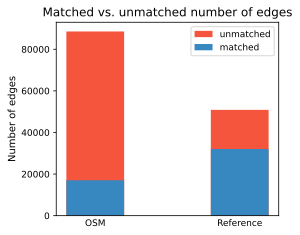

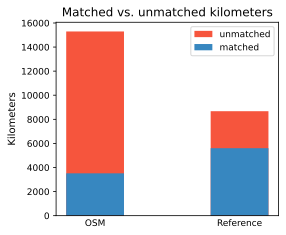

In [12]:
# Plot matching summary

set_renderer(renderer_plot)

# Edges
fig, ax = plt.subplots(1, 1, figsize=pdict["fsbar_small"], sharex=True, sharey=False)
bars = ("OSM", "Reference")
x_pos = [0.5, 1.5]

ax.bar(
    x_pos[0],
    [len(osm_edges_simplified)],
    width=pdict["bar_single"],
    color=pdict["nomatch"],
    label="unmatched",
)
ax.bar(
    x_pos[0],
    [count_matched_osm],
    width=pdict["bar_single"],
    color=pdict["match"],
    label="matched",
)

ax.bar(
    x_pos[1],
    [len(ref_edges_simplified)],
    width=pdict["bar_single"],
    color=pdict["nomatch"],
)
ax.bar(x_pos[1], [count_matched_ref], width=pdict["bar_single"], color=pdict["match"])

ax.set_title("Matched vs. unmatched number of edges")
ax.set_xticks(x_pos, bars)
ax.set_ylabel("Number of edges")
ax.legend()

plot_func.save_fig(fig, compare_results_plots_fp + f"matched_unmatched_edges_{buffer_dist}_{hausdorff_threshold}_{angular_threshold}_compare")

# Kilometers
fig, ax = plt.subplots(1, 1, figsize=pdict["fsbar_small"], sharex=True, sharey=False)
bars = ("OSM", "Reference")
x_pos = [0.5, 1.5]

ax.bar(
    x_pos[0],
    [osm_edges_simplified.geometry.length.sum() / 1000],
    width=pdict["bar_single"],
    color=pdict["nomatch"],
    label="unmatched",
)
ax.bar(
    x_pos[0],
    [length_matched_osm / 1000],
    width=pdict["bar_single"],
    color=pdict["match"],
    label="matched",
)

ax.bar(
    x_pos[1],
    [ref_edges_simplified.geometry.length.sum() / 1000],
    width=pdict["bar_single"],
    color=pdict["nomatch"],
)
ax.bar(
    x_pos[1],
    [length_matched_ref / 1000],
    width=pdict["bar_single"],
    color=pdict["match"],
)

ax.set_title("Matched vs. unmatched kilometers")
ax.set_xticks(x_pos, bars)
ax.set_ylabel("Kilometers")

ax.legend()

plot_func.save_fig(fig, compare_results_plots_fp + f"matched_unmatched_km_{buffer_dist}_{hausdorff_threshold}_{angular_threshold}_compare")

## Analyze feature matching results

### Matched features by infrastructure type 

In [13]:
protection_level_comparison = match_func.update_osm(
    osm_segments,
    osm_edges_simplified,
    segment_matches,
    "protected",
    "edge_id",
    "seg_id",
)

results_feature_matching["protection_level_identical"] = len(
    protection_level_comparison.loc[
        protection_level_comparison.protected
        == protection_level_comparison.protected_matched
    ]
)
results_feature_matching["protection_level_differs"] = len(
    protection_level_comparison.loc[
        protection_level_comparison.protected
        != protection_level_comparison.protected_matched
    ]
)

In [22]:
# Plot infrastructure type of matched features

if plot_static_maps:

    set_renderer(renderer_map)
    fig, ax = plt.subplots(1, 1, figsize=pdict["fsmap"])

    protection_level_comparison.loc[
        protection_level_comparison.protected
        == protection_level_comparison.protected_matched
    ].plot(ax=ax, color=pdict["match"], linewidth=2, label="Same protection level")
    protection_level_comparison.loc[
        protection_level_comparison.protected
        != protection_level_comparison.protected_matched
    ].plot(ax=ax, color=pdict["nomatch"], linewidth=2, label="Different protection levels")

    cx.add_basemap(ax=ax, crs=study_crs, source=cx_tile_2)
    ax.set_title("Infrastructure type of matched features")
    ax.legend()

    ax.set_axis_off()

    plot_func.save_fig(fig, compare_results_static_maps_fp + f"matched_infra_type_{buffer_dist}_{hausdorff_threshold}_{angular_threshold}_compare")


### Feature matching success

In the plots below, the count, percent, and length of matched and unmatched features in each data set are summarized. 

<div class="alert alert-block alert-danger">
<b>Warning</b>
<p>
The number of matched features in one data set in a grid cell does not necessarily reflect the number of matched features in the other data set, since an edge can be matched to a corresponding edge in another cell. Moreover, the local count refers to edges intersected with the grid cell. For example, a long bike lane crossing 3 cells will thus be counted as matched in 3 different cells. This does not change the relative distribution of matched/unmatched features, but it does entail that the overall summary of matched/unmatched features above uses a different total count of edges than the plots below.
</p>
</div>

In [15]:
osm_matched = osm_edges_simp_joined.loc[
    osm_edges_simp_joined.edge_id.isin(osm_matched_ids)
]

ref_matched = ref_edges_simp_joined.loc[
    ref_edges_simp_joined.edge_id.isin(ref_matched_ids)
]

# Count features in each grid cell
data = [osm_matched, ref_matched]
labels = ["osm_matched", "ref_matched"]

for data, label in zip(data, labels):

    df = eval_func.count_features_in_grid(data, label)

    grid = eval_func.merge_results(grid, df, "left")

    df = eval_func.length_of_features_in_grid(data, label)

    grid = eval_func.merge_results(grid, df, "left")

# Get length of features in each grid cell
data = [osm_edges_simp_joined, ref_edges_simp_joined]
labels = ["osm", "ref"]

for data, label in zip(data, labels):

    df = eval_func.length_of_features_in_grid(data, label)

    grid = eval_func.merge_results(grid, df, "left")

# Compute pct matched
grid["pct_matched_osm"] = (
    grid["count_osm_matched"] / grid["count_osm_simplified_edges"] * 100
)
grid["pct_matched_ref"] = (
    grid["count_ref_matched"] / grid["count_ref_simplified_edges"] * 100
)


# Compute local min, max, mean of matched
results_feature_matching["osm_pct_matched_local_min"] = grid.pct_matched_osm.min()
results_feature_matching["osm_pct_matched_local_max"] = grid.pct_matched_osm.max()
results_feature_matching["osm_pct_matched_local_mean"] = grid.pct_matched_osm.mean()
results_feature_matching["ref_pct_matched_local_min"] = grid.pct_matched_ref.min()
results_feature_matching["ref_pct_matched_local_max"] = grid.pct_matched_ref.max()
results_feature_matching["ref_pct_matched_local_mean"] = grid.pct_matched_ref.mean()

# Compute unmatched
grid.loc[
    (grid.count_osm_simplified_edges.notnull()) & (grid.count_osm_matched.isnull()),
    ["count_osm_matched"],
] = 0
grid.loc[
    (grid.count_ref_simplified_edges.notnull()) & (grid.count_ref_matched.isnull()),
    ["count_ref_matched"],
] = 0
grid.loc[
    (grid.count_osm_simplified_edges.notnull()) & (grid.pct_matched_osm.isnull()),
    ["pct_matched_osm"],
] = 0
grid.loc[
    (grid.count_ref_simplified_edges.notnull()) & (grid.pct_matched_ref.isnull()),
    ["pct_matched_ref"],
] = 0

grid.loc[
    (grid.count_osm_simplified_edges.notnull()) & (grid.length_osm_matched.isnull()),
    ["length_osm_matched"],
] = 0
grid.loc[
    (grid.count_ref_simplified_edges.notnull()) & (grid.length_ref_matched.isnull()),
    ["length_ref_matched"],
] = 0

grid["count_osm_unmatched"] = grid.count_osm_simplified_edges - grid.count_osm_matched
grid["count_ref_unmatched"] = grid.count_ref_simplified_edges - grid.count_ref_matched

grid["length_osm_unmatched"] = grid.length_osm - grid.length_osm_matched
grid["length_ref_unmatched"] = grid.length_ref - grid.length_ref_matched

# Compute pct unmatched
grid["pct_unmatched_osm"] = (
    grid["count_osm_unmatched"] / grid["count_osm_simplified_edges"] * 100
)
grid["pct_unmatched_ref"] = (
    grid["count_ref_unmatched"] / grid["count_ref_simplified_edges"] * 100
)

grid.loc[grid.pct_matched_osm == 100, "pct_unmatched_osm"] = 0
grid.loc[grid.pct_matched_ref == 100, "pct_unmatched_ref"] = 0

In [23]:
# Plot of matched features

if plot_static_maps:

    set_renderer(renderer_map)

    # Plot count of matched features
    plot_cols = ["count_osm_matched", "count_ref_matched"]
    plot_titles = [
        area_name + ": OSM features matched to reference data",
        area_name + f": {reference_name} features matched to OSM data",
    ]
    filepaths = [
        compare_results_static_maps_fp
        + f"count_osm_matched_grid_{buffer_dist}_{hausdorff_threshold}_{angular_threshold}_compare",
        compare_results_static_maps_fp
        + f"count_osm_matched_grid_{buffer_dist}_{hausdorff_threshold}_{angular_threshold}_compare",
    ]
    cmaps = [pdict["pos"]] * len(plot_cols)
    no_data_cols = ["count_osm_simplified_edges", "count_ref_simplified_edges"]

    norm_count_min = [0]*len(plot_cols)
    norm_count_max = [grid[["count_osm_matched", "count_ref_matched"]].max().max()]*len(plot_cols)

    plot_func.plot_grid_results(
        grid=grid,
        plot_cols=plot_cols,
        plot_titles=plot_titles,
        filepaths=filepaths,
        cmaps=cmaps,
        alpha=pdict["alpha_grid"],
        cx_tile=cx_tile_2,
        no_data_cols=no_data_cols,
        use_norm=True,
        norm_min=norm_count_min,
        norm_max=norm_count_max,
    )


    # Plot pct of count of matched features
    norm_pct_min = [0]*len(plot_cols)
    norm_pct_max = [100]*len(plot_cols)

    plot_cols = ["pct_matched_osm", "pct_matched_ref"]
    plot_titles = [
        area_name + f": percent of OSM features matched to reference data",
        area_name + f": percent of {reference_name} features matched to OSM data",
    ]
    filepaths = [
        compare_results_static_maps_fp
        + f"pct_osm_matched_grid_{buffer_dist}_{hausdorff_threshold}_{angular_threshold}_compare",
        compare_results_static_maps_fp
        + f"pct_ref_matched_grid_{buffer_dist}_{hausdorff_threshold}_{angular_threshold}_compare",
    ]

    cmaps = [pdict["seq"]] * len(plot_cols)
    no_data_cols = ["count_osm_simplified_edges", "count_ref_simplified_edges"]

    plot_func.plot_grid_results(
        grid=grid,
        plot_cols=plot_cols,
        plot_titles=plot_titles,
        filepaths=filepaths,
        cmaps=cmaps,
        alpha=pdict["alpha_grid"],
        cx_tile=cx_tile_2,
        no_data_cols=no_data_cols,
        use_norm=True,
        norm_min=norm_pct_min,
        norm_max=norm_pct_max,
    )

    # Plot length of matched features
    norm_length_min = [0]*len(plot_cols)
    norm_length_max = [grid[["length_osm_matched", "length_ref_matched"]].max().max()]*len(plot_cols)

    plot_cols = ["length_osm_matched", "length_ref_matched"]
    plot_titles = [
        area_name + f": length of OSM features matched to reference data (m)",
        area_name + f": length of {reference_name} features matched to OSM data (m)",
    ]
    filepaths = [
        compare_results_static_maps_fp
        + f"length_osm_matched_grid_{buffer_dist}_{hausdorff_threshold}_{angular_threshold}_compare",
        compare_results_static_maps_fp
        + f"length_ref_matched_grid_{buffer_dist}_{hausdorff_threshold}_{angular_threshold}_compare",
    ]

    cmaps = [pdict["pos"]] * len(plot_cols)

    plot_func.plot_grid_results(
        grid=grid,
        plot_cols= plot_cols,
        plot_titles=plot_titles,
        filepaths=filepaths,
        cmaps=cmaps,
        alpha=pdict["alpha_grid"],
        cx_tile=cx_tile_2,
        no_data_cols=no_data_cols,
        use_norm=True,
        norm_min=norm_length_min,
        norm_max=norm_length_max,
    )

In [24]:
# Plot of unmatched features

if plot_static_maps:

    set_renderer(renderer_map)

    cmaps = [pdict["neg"]] * len(plot_cols)
    no_data_cols = ["count_osm_simplified_edges", "count_ref_simplified_edges"]

    # Plot count of matched features
    plot_cols = ["count_osm_unmatched", "count_ref_unmatched"]
    plot_titles = [
        area_name + f": OSM features not matched to reference data",
        area_name + f": {reference_name} features not matched to OSM data",
    ]
    filepaths = [
        compare_results_static_maps_fp
        + f"count_osm_unmatched_grid_{buffer_dist}_{hausdorff_threshold}_{angular_threshold}_compare",
        compare_results_static_maps_fp
        + f"count_osm_unmatched_grid_{buffer_dist}_{hausdorff_threshold}_{angular_threshold}_compare",
    ]

    norm_count_min = [0]*len(plot_cols)
    norm_count_max = [grid[["count_osm_unmatched", "count_ref_unmatched"]].max().max()]*len(plot_cols)


    plot_func.plot_grid_results(
        grid=grid,
        plot_cols=plot_cols,
        plot_titles=plot_titles,
        filepaths=filepaths,
        cmaps=cmaps,
        alpha=pdict["alpha_grid"],
        cx_tile=cx_tile_2,
        no_data_cols=no_data_cols,
        use_norm=True,
        norm_min=norm_count_min,
        norm_max=norm_count_max,
    )


    # Plot pct of count of matched features
    plot_cols = ["pct_unmatched_osm", "pct_unmatched_ref"]
    plot_titles = [
        area_name + ": percent of OSM features not matched to reference data",
        area_name + f": percent of {reference_name} features not matched to OSM data",
    ]
    filepaths = [
        compare_results_static_maps_fp
        + f"pct_osm_unmatched_grid_{buffer_dist}_{hausdorff_threshold}_{angular_threshold}_compare",
        compare_results_static_maps_fp
        + f"pct_ref_unmatched_grid_{buffer_dist}_{hausdorff_threshold}_{angular_threshold}_compare",
    ]

    norm_pct_min = [0]*len(plot_cols)
    norm_pct_max = [100]*len(plot_cols)


    plot_func.plot_grid_results(
        grid=grid,
        plot_cols=plot_cols,
        plot_titles=plot_titles,
        filepaths=filepaths,
        cmaps=cmaps,
        alpha=pdict["alpha_grid"],
        cx_tile=cx_tile_2,
        no_data_cols=no_data_cols,
        use_norm=True,
        norm_min=norm_pct_min,
        norm_max=norm_pct_max,
    )

    # Plot length of matched features
    plot_cols = ["length_osm_unmatched", "length_ref_unmatched"]
    plot_titles = [
        area_name + ": length of OSM features not matched to reference data",
        area_name + f": length of {reference_name} features not matched to OSM data",
    ]
    filepaths = [
        compare_results_static_maps_fp
        + f"length_osm_unmatched_grid_{buffer_dist}_{hausdorff_threshold}_{angular_threshold}_compare",
        compare_results_static_maps_fp
        + f"length_ref_unmatched_grid_{buffer_dist}_{hausdorff_threshold}_{angular_threshold}_compare",
    ]

    norm_length_min = [0]*len(plot_cols)
    norm_length_max = [grid[["length_osm_unmatched", "length_ref_unmatched"]].max().max()]*len(plot_cols)

    plot_func.plot_grid_results(
        grid=grid,
        plot_cols=plot_cols,
        plot_titles=plot_titles,
        filepaths=filepaths,
        cmaps=cmaps,
        alpha=pdict["alpha_grid"],
        cx_tile=cx_tile_2,
        no_data_cols=no_data_cols,
        use_norm=True,
        norm_min=norm_length_min,
        norm_max=norm_length_max,
    )

## Summary

In [18]:
osm_keys = [x for x in results_feature_matching.keys() if "osm" in x]
ref_keys = [x for x in results_feature_matching.keys() if "ref" in x]

osm_values = [results_feature_matching[x] for x in osm_keys]
osm_df = pd.DataFrame(osm_values, index=osm_keys)

osm_df.rename({0: "OSM"}, axis=1, inplace=True)

# Convert to km
osm_df.loc["osm_matched_length"] = osm_df.loc["osm_matched_length"] / 1000

rename_metrics = {
    "osm_matched_count": "Count of matched edges",
    "osm_matched_count_pct": "Percent matched edges",
    "osm_matched_length": "Length of matched edges (km)",
    "osm_matched_length_pct": "Percent of matched network length",
    "osm_pct_matched_local_min": "Local min of % matched edges",
    "osm_pct_matched_local_max": "Local max of % matched edges",
    "osm_pct_matched_local_mean": "Local average of % matched edges",
}

osm_df.rename(rename_metrics, inplace=True)

ref_keys = [x for x in results_feature_matching.keys() if "ref" in x]

ref_values = [results_feature_matching[x] for x in ref_keys]
ref_df = pd.DataFrame(ref_values, index=ref_keys)

# Convert to km
ref_df.loc["ref_matched_length"] = ref_df.loc["ref_matched_length"] / 1000

ref_df.rename({0: reference_name}, axis=1, inplace=True)

rename_metrics = {
    "ref_matched_count": "Count of matched edges",
    "ref_matched_count_pct": "Percent matched edges",
    "ref_matched_length": "Length of matched edges (km)",
    "ref_matched_length_pct": "Percent of matched network length",
    "ref_pct_matched_local_min": "Local min of % matched edges",
    "ref_pct_matched_local_max": "Local max of % matched edges",
    "ref_pct_matched_local_mean": "Local average of % matched edges",
}

ref_df.rename(rename_metrics, inplace=True)
combined_results = pd.concat([osm_df, ref_df], axis=1)

combined_results.style.pipe(format_matched_style)

,OSM,GeoDanmark
Count of matched edges,"17,014","32,055"
Percent matched edges,19%,63%
Length of matched edges (km),"3,515","5,600"
Percent of matched network length,23,65
Local min of % matched edges,1%,2%
Local max of % matched edges,100%,100%
Local average of % matched edges,53%,88%


In [23]:
# Export to CSV

combined_results.to_csv(
    compare_results_data_fp + "feature_matching_summary_stats.csv", index=True
)

## Save results

In [24]:
with open(
    f"../../results/compare/{study_area}/data/feature_matches_{buffer_dist}_{hausdorff_threshold}_{angular_threshold}.json",
    "w",
) as outfile:
    json.dump(results_feature_matching, outfile)

grid.to_parquet(ref_results_data_fp + f"grid_results_feature_matching_{buffer_dist}_{hausdorff_threshold}_{angular_threshold}.parquet")

***

In [ ]:
from time import strftime
print("Time of analysis: " + strftime("%a, %d %b %Y %H:%M:%S"))